# Import Libraries and load data


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern

In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
## Preprocess
# Convert labels to numerical values
y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# PCA
The given plot illustrates the relationship between the principal component number and the proportion of variance explained. It serves as a useful tool to determine the appropriate number of principal components to retain for dimensionality reduction. By examining the scree plot, we can identify a point where there is a noticeable change in the proportion of variance explained, resembling the shape of an elbow. This point indicates a heuristic or rule of thumb for selecting the number of principal components to retain in order to effectively reduce the dimensionality of the data.

In [3]:
# Reshape the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Standardize the feature values
scaler = StandardScaler()
X_train_fit = scaler.fit_transform(X_train)
X_test_fit = scaler.transform(X_test)
print(X_train.shape)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca.fit(X_train_fit)
X_train_PCA = pca.fit_transform(X_train_fit)
X_test_PCA = pca.transform(X_test_fit)
print(X_train.shape)



(50000, 3072)
(50000, 3072)


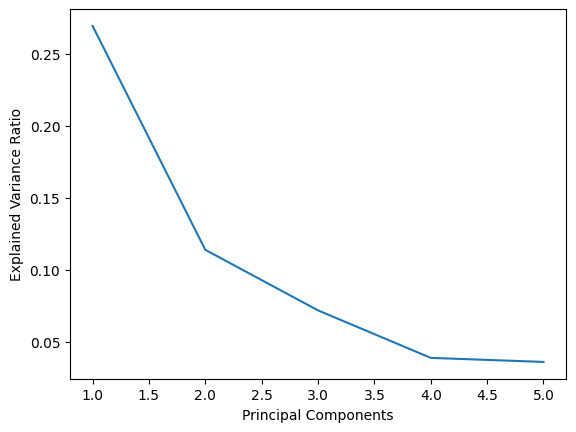

In [4]:
x = [1,2,3,4,5]
y = pca.explained_variance_ratio_[:5]
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [5]:
E= pca.components_[:10]
E.shape

(10, 3072)

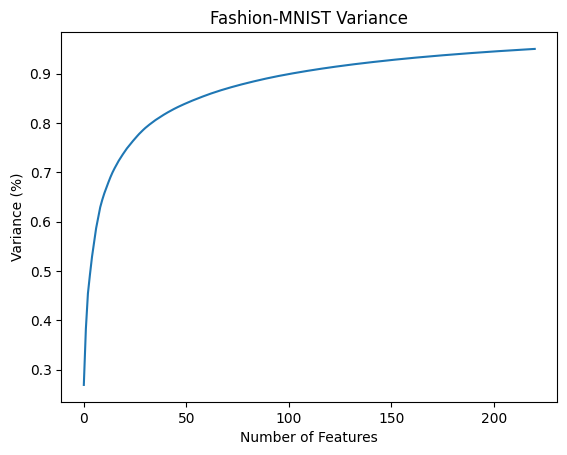

In [6]:
# Plot the cumulative sum of eigenvalues
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Variance (%)') #for each component
plt.title('Fashion-MNIST Variance')
plt.show()

# Decision tree classification system applied on extracted features using PCA


In [7]:
max_depth = 8
# min_samples_split = 80
# min_samples_leaf = 60

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=max_depth)

# Train the classifier on the training data
clf.fit(X_train_PCA, y_train)





DecisionTreeClassifier(max_depth=8)

In [8]:
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
is_leaves = np.zeros(shape=clf.tree_.node_count, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
#     node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

In [9]:
num_leaves = 0
for i in range(len(is_leaves)):
    if(is_leaves[i] == True):
        num_leaves +=1
print('Number of leaf nodes',num_leaves)

Number of leaf nodes 255


In [10]:
# Make predictions on the test data
y_pred_train = clf.predict(X_train_PCA)
y_pred = clf.predict(X_test_PCA)

# Calculate accuracy
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_pred_train, y_train)
print("Accuracy:", accuracy_test)
print("Accuracy:", accuracy_train)

Accuracy: 0.3078
Accuracy: 0.33546


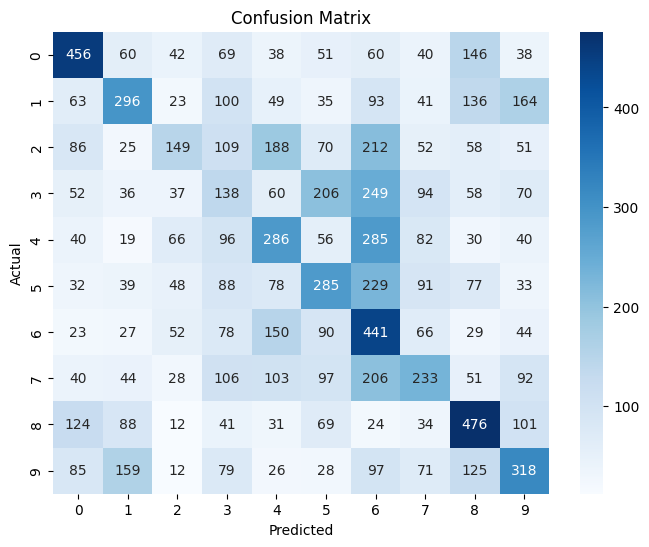

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
print(clf.tree_.node_count)
print(clf.tree_.max_depth)

509
8


# Auto Encoder


In [13]:
import collections
from sklearn import preprocessing
from IPython.display import Markdown, display
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model

%matplotlib inline

In [14]:
from keras.datasets import cifar100
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np



filepath = "save/cnn_autoencoder.hdf5"
learning_rate = 0.001
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()


# Define input size
input_size = (32, 32, 3)

input_image = Input(shape=input_size)

# Encoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), padding='same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
autoencoder.summary()

# Normalize and reshape input data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 encoded_layer (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = autoencoder.fit(x_train, x_train, validation_split=0.1, callbacks=[monitor, checkpointer], verbose=1, epochs=30, batch_size=32, shuffle=True)

Epoch 1/30
1407/1407 [==============================] - 26s 12ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 2/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/30
1407/1407 [==============================] - 17s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/30
1407/1407 [==============================] - 17s 12m

In [16]:
model = load_model('save/cnn_autoencoder.hdf5')
encoder_feature = Model(inputs=model.input, outputs=model.get_layer('encoded_layer').output)

In [17]:
autoencoder_features_train = encoder_feature.predict(x_train)
autoencoder_features_test = encoder_feature.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [18]:
autoencoder_features_train.shape

(50000, 8, 8, 128)

In [19]:
autoencoder_features_train_flat = autoencoder_features_train.reshape(autoencoder_features_train.shape[0], autoencoder_features_train.shape[1] * autoencoder_features_train.shape[2] * autoencoder_features_train.shape[3])
autoencoder_features_test_flat = autoencoder_features_test.reshape(autoencoder_features_test.shape[0], autoencoder_features_test.shape[1] * autoencoder_features_test.shape[2] * autoencoder_features_test.shape[3])

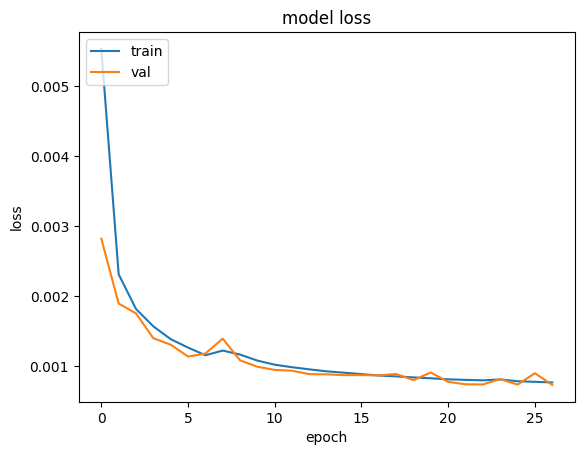

In [20]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Decision tree classification system applied on extracted features using Auto Encoder


In [21]:
max_depth = 6
min_samples_split = 80
min_samples_leaf = 60

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=max_depth)

# Train the classifier on the training data
clf.fit(autoencoder_features_train_flat, y_train)

DecisionTreeClassifier(max_depth=6)

In [22]:
# Make predictions on the test data
y_pred_train = clf.predict(autoencoder_features_train_flat)
y_pred = clf.predict(autoencoder_features_test_flat)

# Calculate accuracy
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_pred_train, y_train)
print("Accuracy:", accuracy_test)
print("Accuracy:", accuracy_train)

Accuracy: 0.3271
Accuracy: 0.34018


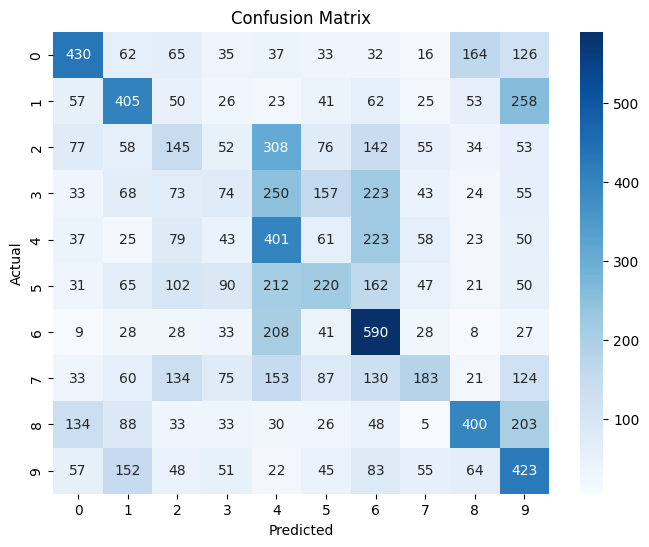

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
